# Proxy Discrimination: A Descrption of the Problem, a Mitigation Approach, and Usage of the Implementation `DiscriminationMitigator`

## Proxy Discrimination

To illustrate the problem of discrimination by proxy, we synthesize data with a continuous target variable *y*, a binary protected class feature with two dummies for category *c1* and *c0*, and covariates *w1* and *w2*, which are linear functions of class membership and random noise. The target variable *y* is determined by covariates, independent normal draws, and class category membership. Class category differences in *y* can be thought of many ways. We find it most convenient to interpret it as representing unobserved causal variables that are correlated with protected class, but it could also represent statistical discrimination or taste-based discrimination that directly biases observation of the target variable.

In [50]:
import json
from DiscriminationMitigation import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # turn off tensorflow warning messages

In [51]:
# Function to create a Tensorflow Keras deep learning model
def keras_model():
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.01))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.01))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to aggregate a dataframe according to a rounded feature, 'w0'
def aggregate_data(df):
    df = pd.concat([df, synth[['w0']].reset_index(drop=True)], axis=1)
    df['w0'] = round(df['w0'], 1)
    df = df.sort_values(by=['w0'])
    return df.groupby(['w0']).mean()

### Instantiate synthetic data

In [52]:
def simple_synth(n=8000, class_prob=0.5, gamma=np.matrix([[2,3.5],[.4,.6]]), alpha=np.matrix([[0,2]]), 
                 beta=np.matrix([[2,2],[1,1]])):
    
    np.random.seed(1776)

    # Protected class variable
    c1 = np.random.binomial(1, p=class_prob, size=n) # group 1
    c0 = 1-c1 # group 0

    # Other covariates
    w0 = gamma[0,0]*c0 + gamma[0,1]*c1 + np.random.normal(0, 0.5, size=n) # linear function of class & shock
    w1 = gamma[1,0]*c0 + gamma[1,1]*c1 + np.random.normal(0, 0.3, size=n)
                                                                 
    # Outcome variable
    y = alpha[0,0]*c0 + alpha[0,1]*c1 + beta[0,0]*c0*w0 + beta[0,1]*c1*w0 + beta[1,0]*c0*w1 + beta[1,1]*c1*w1 + \
        np.random.normal(0, 0.3, size=n)

    return pd.DataFrame([y, c0, c1, w0, w1]).T.rename(columns={0:'y', 1: 'c0', 2: 'c1', 3: 'w0', 4:'w1'})

In [53]:
synth = simple_synth()
print(synth.head())
print("\n", synth.shape)

          y   c0   c1        w0        w1
0  4.673528  1.0  0.0  2.214135  0.324108
1  7.939870  0.0  1.0  2.404301  1.070192
2  5.222822  1.0  0.0  2.338783  0.519127
3  9.406248  0.0  1.0  3.145858  0.822292
4  3.990423  1.0  0.0  1.523643  0.897265

 (8000, 5)


### Visualizing between group and within group variation

Fundamentally, if cross-group differences in the distribution of the target variable remain after accounting for observables, then there exists a risk that a model predicting the target will discriminate on the basis of group membership -- whether or not group variables are included in the the model. 

The following series of figures illustrate statistical discrimination against groups and how it can occur even when class variables are omitted from the model.


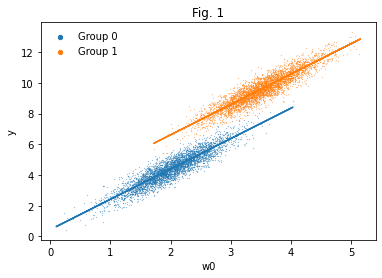

In [142]:
c0_grp = synth.loc[synth["c0"] == 1]
c1_grp = synth.loc[synth["c1"] == 1]

# Estimate fitted values from a linear regression model
c0_pred = LinearRegression().fit(c0_grp[["w0"]], c0_grp["y"]).predict(c0_grp[["w0"]])
c1_pred = LinearRegression().fit(c1_grp[["w0"]], c1_grp["y"]).predict(c1_grp[["w0"]])

# Scatter & line plot using Matplotlib
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(c0_grp["w0"], c0_pred)
plt.plot(c1_grp["w0"], c1_pred)
plt.title('Fig. 1')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25, frameon=False)
plt.show()

Both within group and between group variation can drive associations. 

The scatterplot in figure 1 distinguishes between two groups, whose data are distributed differently.  Within both groups, there is a positive releationship between the target variable and the covariate `w0`. `Group 0` has lower values of `w0`, so one would expect it to have lower values of the target.  In fact, it has *much* lower values of the target, which cannot be entirely explained by lower values in the covariate.  

Running seperate regressions for each group (or including separate intercepts in a single regression) yields the parallel regression lines with different intercepts.  The line for `Group 0` is shifted down by the difference in intercepts.  

**This difference in intercepts represents predictive information in group membership**.  Even after accounting for all other covariates, there exists differences in the target between groups. That is, group membership contains additional information, which can be used to improve the prediction.  Exploiting this information in some decision rule would constitute statistical discrimination. 

It may be obvious that statistical discrimination occurs when this information is exploited directly by explictly using group membership when making predictions.  But statistical discrimination can also occur when this information is exploited indirectly, where group membership is implicit in the values of covariates.

For this discussion, we will consider two predictive models: 

the **comprehensive model**:  `f(w0,g1)`

and 

the **group-excluded model**:  `f(w0)`.  


### Group membership can predict outcomes even when group is excluded from predictive model 

In [140]:
# Scatter & line plot using Matplotlib
# Train a Tensorflow Keras deep learning model
model = keras_model()
model.fit(synth[['w0']], synth['y'], epochs=60, batch_size=128, verbose=0)
pred = model.predict(synth[['w0']]) # Generate prediction from model

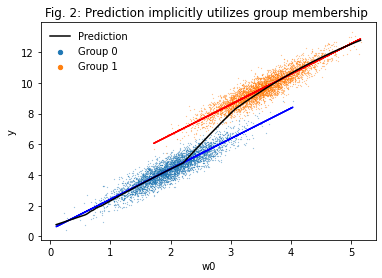

In [141]:
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(c0_grp["w0"], c0_pred, color = "blue")
plt.plot(c1_grp["w0"], c1_pred, color = "red")

plt.plot(synth.sort_values(by="w0")[['w0']], model.predict(synth.sort_values(by="w0")[['w0']]), 
         label='Prediction', color="black")
plt.title('Fig. 2: Prediction implicitly utilizes group membership ') # do NOT use 'bias'. There is a concrete statistical definition of bias, which does not apply here.  And then there are vague non-statistical ideas of bias which may or may not apply here. 
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25, frameon=False)
plt.show()

Because group membership is implicit in the values of covariates, removing group membership from a predictive model is not sufficient to prevent the model from predicating its predictions upon group membership.  That is, decisions based on the fitted group-excluded model can still statistically discriminate.    

Based on standard intuition concerning residual regression and omitted variable bias in linear regression, the predictive content of any variable can be decomposed into a component mediated through predictions of the omitted variables and a direct, unmediated component.  If group variables are omitted from a model, then coefficient estimates on other models will incorporate indirect effects through the group variables.  Consequently, a portion of any forecast will be driven by forecasts of the omitted group variables. 

This intuition also applies to non-linear models, including machine learning models like neural nets or gradient boosted trees. 
To illustrate this point, we fit a neural net for predicting `y` using only the covariate `w0`, the fitted values of which yield the black upward-sloping s-shaped curve in figure 2. For low values of `w0`, the black curve overlays the regression line for group 0, matching the within-group association between changes in `y` and changes in `w0`. But for intermediate values of `w0`, the prediction slopes up more steeply, moving from the group 0 regression line and towards the group 1 regression line, after which it flattens out again to match the group 1 regression line.  

This black prediction line can be conceptualized as a weighted-average of within-group predictions, where the weights depend upon `w0`.  That is, for values of `w0` between 0 and 2, the person is most likely from group zero.  But as `w0` moves from 2 to 3, probable membership rapidly shifts to group 1, and the weight on the group 1 regression line increases at the expense of the weight on the group 0 regression line. That is, part of the prediction from `w0` comes from the within-group assocation between `w0` and `y`,  and part of it comes the between-group difference in means times predicted group membership. 




### A model that excludes group will yield similar target predictions as a model that includes group for training but uses probability of group membership for predicting

In [78]:
# predict probability person is in group 1 given w0
c1_prob_model = keras_model()
c1_prob_model.fit(synth['w0'], synth[['c1']], epochs=60, batch_size=128, verbose=0)
c1_prob_fit = c1_prob_model.predict(synth[['w0']]) 

# fit model of y given group membership and 
w0_and_class_model = keras_model()
w0_and_class_model.fit(synth[['c1', 'w0']], synth['y'], epochs=60, batch_size=128, verbose=0)

# predict y, but only after replacing class with predicted class membership.  
synth_with_predicted_class = synth.copy()
synth_with_predicted_class[['c1']] = c1_prob_fit
synth_with_predicted_class = synth_with_predicted_class.sort_values(by='w0')
pred_using_predicted_class = w0_and_class_model.predict(synth_with_predicted_class[['c1', 'w0']]) # Generate prediction from model


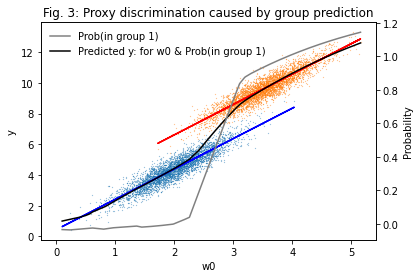

In [138]:

fig, ax1 = plt.subplots()
plt.title('Fig. 3: Proxy discrimination caused by group prediction')
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(c0_grp["w0"], c0_pred, color = "blue")
plt.plot(c1_grp["w0"], c1_pred, color = "red")

ax1.plot(synth_with_predicted_class[['w0']], 
         pred_using_predicted_class, 
         label='Prediction using predicted class', color="black")
#plt.legend()
plt.ylabel('y')
plt.xlabel('w0')

ax2 = ax1.twinx() 
ax2.plot(synth_with_predicted_class[['w0']], synth_with_predicted_class[['c1']], 
         color="grey", label = "Prob(in group 1)")
ax2.plot(np.array([0]), np.array([0]), #this line is purely a hack to get this label to show up in legend. 
         color="black", label = "Predicted y: for w0 & Prob(in group 1)")

plt.ylabel('Probability')
plt.legend(markerscale=25, frameon=False)
plt.show()

Figure 3 clarifies prior intuition, showing how a component of `w0` predicts they target by predicting group membership membership.

To produce figure 3, we:
1. **Fit a model using both group membership `c1` and covariate `w0` as predictors**.
2. **Fit probabilities of group membership `c1` as a function of `w0`** (plotted as the grey line). The probabilities of group membership are estimated using a neural net (indeed, using one with the exact same structure as that used to predict the target).  By happenstance the probabilities do not fall between 0 and 1.  However, these details are immaterial.
3. **Predict the target `y`** (plotted as the black line) **using the model from step 1, but only after replacing person group membership with fitted probability of group membership.**

Note that the black line, which predicts the target in part by explitly using predicted group membership, is substantively identical to the black line from figure 2, which predicted the target using a model that excluded group membership.  It is in this sense that we say a component of the covariates proxies for group membership; excluding group membership from the model is not sufficient to prevent the model from statistically discriminating.  





### Predictions using constant counterfactual group membership do admit proxy discrimination

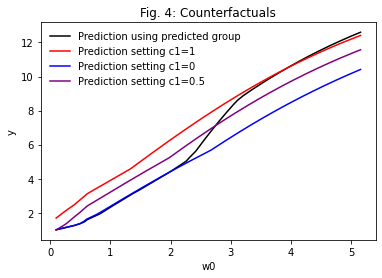

In [137]:
pred_using_predicted_class = w0_and_class_model.predict(synth_with_predicted_class[['c1', 'w0']]) # Generate prediction from model
synth_counterfactual_class = synth_with_predicted_class.copy()
synth_counterfactual_class[['c1']] = 1
pred_using_c1_as_1 = w0_and_class_model.predict(synth_counterfactual_class[['c1', 'w0']])
synth_counterfactual_class[['c1']] = 0
pred_using_c1_as_0 = w0_and_class_model.predict(synth_counterfactual_class[['c1', 'w0']])
synth_counterfactual_class[['c1']] = 0.5
pred_using_c1_as_half = w0_and_class_model.predict(synth_counterfactual_class[['c1', 'w0']])


plt.title('Fig. 4: Counterfactuals')

plt.plot(synth_with_predicted_class[['w0']], 
         pred_using_predicted_class, 
         label='Prediction using predicted group', color="black")
plt.plot(synth_with_predicted_class[['w0']], 
         pred_using_c1_as_1 , 
         label='Prediction setting c1=1', color="red")
plt.plot(synth_with_predicted_class[['w0']], 
         pred_using_c1_as_0 , 
         label='Prediction setting c1=0', color="blue")
plt.plot(synth_with_predicted_class[['w0']], 
         pred_using_c1_as_half , 
         label='Prediction setting c1=0.5', color="purple")


#plt.legend()
plt.ylabel('y')
plt.xlabel('w0')

plt.legend(markerscale=25, frameon=False)
plt.show()

In figure 4, we use the fitted model from the prior section, but we form predictions under four different group membership counterfactuals:
1. As before, the black line uses probability of group membership (as a function of `w0`) in place of actual group membership. 
2. The red line treats all persons as though they were members of group 1 -- and for this reason tracks the regression line for group 1. 
3. Likewise, the blue line treats all persons as though they were members of group 0.  
4. Meanwhile, the purple line treats all persons as though there were in group 1 with 1/2 probability.  

Counterfactual forecasts 2 through 4 do not statistically discrminate -- explicitly or implicitly. Because the counterfactual predictions are based on the comprehensive model, the predictive content of covariates comes from their direct effects -- and not their predictiveness of group membership. Thus, the counterfactual predictions do not discriminate by proxy. Note, however, that mitigated predictions differ across groups.  Average predictions are higher for group 1 in all cases, but the difference in means is lower for the group counterfactual predictions. A discrimination mitigated prediction does not ensure equal predictions, but it does ensure that the the predictions are not made on the basis of group membership -- either directly or indirectly.  

#### Quantifying proxy discrimination 

Meanwhile, proxy statistical discrimination in the group-excluded model can be quantified by comparing its predictions with those of the counterfactual comprehensive model. For example, an observation from group 0 and with `w0=1` would be predicted to have about `y=2` under both the group-excluded model and the comprehensive model with group membership at 0. But setting counterfactual group membership to 1 yields a prediction of about `y=4`.  Setting the counterfactual group membership to 0.5 -- the population share of group 1 -- yields a prediction of `y=1`, indicating that proxy discrimination in the group-excluded model accounts for an approximate 1 unit decrement from a flat prior on group membership at this level of `w0`.  Similarly, proxy discrimination accounts for an approximate 2 unit increment in the forecasts at high levels of `w0`.  When `w0` approximately equals 2.5 the group-excluded model does not statistically discriminate. 

#### To predict using average counterfactual values, or to average predictions across counterfactual values?

Although counterfactual prediction 4 used a value of 0.5 in this pedagogical example, in general we advise against non-integer counterfactuals for interger variables.  This is because non-integer values are outside the domain of the data, and loss caused by non-linearities at non-integer points are not penalized. 

Instead of forming predicitions on a weighted average of counterfactuals...

   `pred = f(c1 = weight1 * 1 + weight0 * 0, w0 = w0_i)` 

...we recommend taking a weighted average of predictions under different counterfactuals

   `pred = weight1 * f(c1 = 1, w0=w0_i) + weight0 * f(c1 = 1, w0=w0_i)`

which ensures that the comprehensive model's arguments are within its domain.  

It is this approach that we implement in our discrimination mitigator.  Conceptually, the mitigator is a 'functional' (or 'closure'): 

1. The mitigator accepts a fitted model -- a function with covariates and group variables as arguments .
2. The mitigator returns a fitted model as a function of only the covariates.  This mitigated model requries additional parameters -- the weights used for averaging counterfactual forecasts.   

The choice of weights is largely arbitrary (reasonable choices might include uniform weights or population share), but, depending on the process being modeled, might have large effects on the forecast, including the relative ranking of groups. Users should check the mitigated forecast for sensitivity to weights. 

Both a model trained on only covariates and the mitigated model accept only covariates as arguments.  But because the pre-mitigated model included group membership durring training, the mitigated model does not proxy discriminate.

Below we provide detail guidance on utilizing the discrimination mitigator. 


# Using `DiscriminationMitigator`

To use DiscriminationMitigator, users will need to specify two objects. First, a configuration JSON file (see example below). Second, a pre-trained LightGBM or Tensorflow Keras machine learning model.

### Basic setup

#### Specify a configuration file

In [119]:
with open('example_config.json') as j:
    config = json.load(j)
print("Example configuration dictionary: \n", config)

Example configuration dictionary: 
 {'protected_class_features': ['c0', 'c1']}


The config file requires users specify the protected class feature(s) as a list. Any features estimated in the model but not included in this list are assumed to be non-protected classe features.

#### Take a pre-trained LightGBM or Tensorflow Keras model (sequential/model)
*NOTE: PROTECTED CLASS FEATURE(S) MUST BE INCLUDED IN THE TRAINING MODEL!!*

In [125]:
# Note - we estimate the same model as directly above for clarity
comprehensive_model = keras_model()
comprehensive_model.fit(synth[['c0', 'c1', 'w0']], synth['y'], epochs=60, batch_size=128, verbose=0)

#### Instantiate `DiscriminationMitigator` class & call `predictions()` method

In [121]:
mitigated = DiscriminationMitigator(df=synth[['c0', 'c1', 'w0']], model=model, 
                              config=config).predictions()
print(mitigated.head())
print("\n", mitigated.describe())

   unadj_pred  unif_wts
0    4.848831  5.887472
1    7.269607  6.291818
2    5.079812  6.154059
3    8.948738  7.858108
4    3.467535  4.306634

         unadj_pred     unif_wts
count  8000.000000  8000.000000
mean      7.011674     6.969845
std       2.782035     1.912475
min       1.538481     1.391507
25%       4.416570     5.391373
50%       6.928347     6.988325
75%       9.673743     8.612492
max      12.278322    11.423273


,unadj_pred,unif_wts
0,4.848831,5.887472
1,7.269607,6.291818
2,5.079812,6.154059
3,8.948738,7.858108
4,3.467535,4.306634
...,...,...
7995,9.604948,8.536507
7996,12.237442,11.376037
7997,5.174450,6.263462
7998,3.843930,4.739778


The default specification returns a Pandas DataFrame with two features: `unadj_pred`, which is the unadjusted prediction, and `unif_wts`, which is the average of counterfactual predictions (i.e. uniform weights). This first column is equivalent to the prediction in Fig. 3 above.

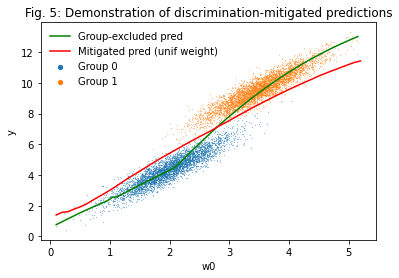

In [136]:
avg = aggregate_data(mitigated) # Average by rounded 'w0'
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)

group_excluded_model = keras_model()
group_excluded_model.fit(synth[['w0']], synth['y'], epochs=60, batch_size=128, verbose=0)
group_excluded_pred = group_excluded_model.predict(synth.sort_values(by='w0')[['w0']])
plt.plot(synth.sort_values(by='w0')[['w0']], group_excluded_pred, label='Group-excluded pred', color='green')
plt.plot(avg['unif_wts'], label='Mitigated pred (unif weight)', color='red')
plt.title('Fig. 5: Demonstration of discrimination-mitigated predictions')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25, frameon=False)
plt.show()

### Option 1: Reweight predictions using the joint distributions of another dataset

In [148]:
# Split the data into train/val and test sets
X_train, X_test, y_train, y_test = train_test_split(synth.loc[:, ['c0', 'c1', 'w0']],
                                                    synth['y'], random_state=1776,
                                                    test_size=0.2)
# Train / val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=123, 
                                                  test_size=0.2)

for x in X_train, X_val, X_test:
    print(x.shape)

(5120, 3)
(1280, 3)
(1600, 3)


In [149]:
# Reestimate the model
model = keras_model()
model.fit(X_train, y_train, epochs=60, batch_size=128, validation_data=(X_val, y_val), verbose=0)

In [150]:
mitigated = DiscriminationMitigator(df=X_test, model=model, 
                              config=config, train=X_train).predictions()

print(mitigated.head())
print("\n", mitigated.describe())

      unadj_pred  unif_wts   pop_wts
6899    9.454874  8.362311  8.352135
163    10.210793  9.170047  9.160646
4780    9.672275  8.589831  8.579865
1891    5.387239  6.442693  6.433375
5372    7.593997  6.630492  6.620881

         unadj_pred     unif_wts      pop_wts
count  1600.000000  1600.000000  1600.000000
mean      6.879675     6.808018     6.799572
std       2.774722     1.974375     1.972947
min       1.909169     1.829329     1.829689
25%       4.287906     5.123645     5.116427
50%       6.194155     6.788368     6.778511
75%       9.614467     8.529239     8.519215
max      12.108476    11.339855    11.333048


Optionally, `DiscriminationMitigator` allows users to reweight predictions to reflect the joint distributions of the protected class feature(s) in another dataset. This may be advantageous, for example, if your test set is considerably smaller than your training set. In this case, `unif_wts` reflects the joint distributions of `df` (i.e. uniform weights; the default), while `pop_wts` reflects the joint distributions of `train`.

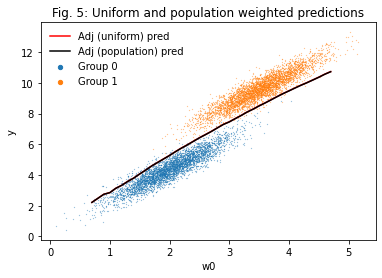

In [155]:
avg = aggregate_data(mitigated) # Average by rounded 'w0'
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(avg['unif_wts'], label='Adj (uniform) pred', color='red')
plt.plot(avg['pop_wts'], label='Adj (population) pred', color='black')
plt.title('Fig. 5: Uniform and population weighted predictions')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25, frameon=False)
plt.show()

### Option 2: Custom reweighting of select feature marginal distributions

In [152]:
with open('example_weights.json') as j:
    weights = json.load(j)
print(weights)

{'c0': {'1': 0.9, '0': 0.1}, 'c1': {'1': 0.1, '0': 0.9}}


By default, DiscriminationMitigator uses uniform weights.  However, DiscriminationMitigator admits custom weights as arguments.

Custom weights are specified by providing a dictionary of custom marginal distributions to `weights`. Importantly, feature marginals must sum to 1.0, otherwise this will produce a ValueError. At present only marginal distributions of select featrures can be reweighted -- not joint distributions. 

Users may prefer to use custom weights for several reasons.  Among these, a user might be concerned that the choice of weights is driving predictions, as might occour if within-group correlations sharply differ across groups.  In this case, choice of weights might affect the ranking of group-mean forecasts, which a user could investigate.  

Altneratively, a user might choose to investigate how group membership colors interpretation of other variables.  For example, what would the model forecast for men if they had the covariates of women?  Subset the data to women and set the weights to 1 on the male group.  What would the model forecast for women if they had the covariates of men?  The relationship is not necessarily symmetric, but the mode of investigation is.  

In [153]:
mitigated = DiscriminationMitigator(df=X_test, model=model, 
                              config=config, train=X_train, weights=weights).predictions()
print(mitigated.head())
print("\n", mitigated.describe())

      unadj_pred  unif_wts   pop_wts  cust_wts
6899    9.454874  8.362311  8.352135  7.498324
163    10.210793  9.170047  9.160646  8.391625
4780    9.672275  8.589831  8.579865  7.751444
1891    5.387239  6.442693  6.433375  5.608274
5372    7.593997  6.630492  6.620881  5.771630

         unadj_pred     unif_wts      pop_wts     cust_wts
count  1600.000000  1600.000000  1600.000000  1600.000000
mean      6.879675     6.808018     6.799572     6.069417
std       2.774722     1.974375     1.972947     1.881425
min       1.909169     1.829329     1.829689     1.886499
25%       4.287906     5.123645     5.116427     4.465684
50%       6.194155     6.788368     6.778511     5.909113
75%       9.614467     8.529239     8.519215     7.683946
max      12.108476    11.339855    11.333048    10.785650



Warning! The following features are extremely correlated and thus may be one-hot vectors: c0 c1. 
If no category is omitted, users must ensure custom marginal weights for one-hot vectors align correctly.


In the presence of custom weights, `DiscriminationMitigator` raises a warning if any features appear extremely correlated, suggesting they may be mutually exclusive one-hot vectors and that custom weights should therefore reflect their complementarity in the underlying data. In our case, the joint distributions of protected class features `c0` and `c1` are polar opposites, meaning we need to reweight *both* of these features. `DiscriminationMitigator`, however, does not enforce that custom weights of adjacent one-hot vectors do in fact sum to 1. 

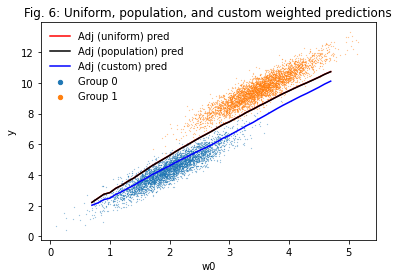

In [156]:
avg = aggregate_data(mitigated) # Average by rounded 'w0'
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(avg['unif_wts'], label='Adj (uniform) pred', color='red')
plt.plot(avg['pop_wts'], label='Adj (population) pred', color='black')
plt.plot(avg['cust_wts'], label='Adj (custom) pred', color='blue')
plt.title('Fig. 6: Uniform, population, and custom weighted predictions')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25, frameon=False)
plt.show()